In [1]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pyeit.mesh as mesh
import tensorflow as tf
from PIL import Image
from pyeit.mesh.shape import thorax
from sciopy import norm_data, plot_mesh
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from support import GREIT_sample, show_mesh
from tensorflow import GradientTape, exp, keras, reduce_mean, reduce_sum, shape, square
from tensorflow.keras import layers, models
from tensorflow.keras.losses import Huber, binary_crossentropy, mse
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model
from tqdm import tqdm

2023-11-02 15:32:26.723638: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


![gif](../codes/r_traj.gif)

In [2]:
l_path = "../data/h0=0.05_n_el=16_r_obj=0.3_dist_exc=8_step_meas=4noise=TrueT=10/"

In [3]:
tmp = np.load(l_path + "sample_000000.npz", allow_pickle=True)
tmp.files

['anomaly',
 'perm_array',
 'n_el',
 'h0',
 'v_empty',
 'v_obj',
 'dist_exc',
 'step_meas']

In [4]:
# create empty mesh:
mesh_obj = mesh.create(tmp["n_el"], h0=tmp["h0"])

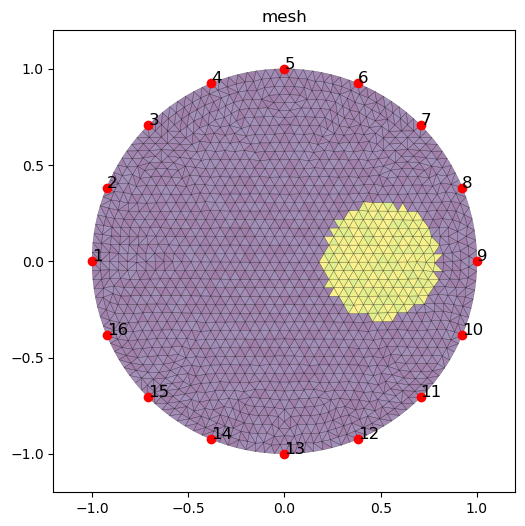

In [5]:
mesh_obj.perm = tmp["perm_array"]
plot_mesh(mesh_obj)

In [6]:
V = list()
posis_xy = list()
perms = list()

for ele in tqdm(np.sort(os.listdir(l_path))):
    tmp_l = np.load(l_path + ele, allow_pickle=True)
    V.append(tmp_l["v_obj"])
    posis_xy.append(tmp_l["anomaly"].tolist().center)
    perms.append(tmp_l["perm_array"])

V = np.array(V)
perms = np.array(perms)
posis_xy = np.array(posis_xy)

100%|██████████| 10000/10000 [00:20<00:00, 489.73it/s]


In [7]:
perms = np.expand_dims(perms,2)

## Build VAE

In [8]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
perms.shape

(10000, 2821, 1)

In [10]:
3200/800

4.0

In [11]:
latent_dim = 4

encoder_inputs = keras.Input(shape=(2821, 1))
x = layers.ZeroPadding1D((379,0))(encoder_inputs)
x = layers.Conv1D(4, activation="relu", kernel_size=4, strides=4, padding="same")(x)
x = layers.Conv1D(16, activation="relu", kernel_size=4, strides=4, padding="same")(x)
x = layers.Conv1D(32, activation="relu", kernel_size=2, strides=2, padding="same")(x)
x = layers.Conv1D(64, activation="relu", kernel_size=2, strides=2, padding="same")(x)
x = layers.Conv1D(32, activation="relu", kernel_size=2, strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

z = Sampling(name="z")([z_mean, z_log_var])
# z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2821, 1)]    0           []                               


2023-11-02 15:33:01.597018: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46722 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2023-11-02 15:33:01.598715: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46722 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 3200, 1)     0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 800, 4)       20          ['zero_padding1d[0][0]']         
                                                                                                  
 conv1d_1 (Conv1D)              (None, 200, 16)      272         ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 100, 32)      1056        ['conv1d_1[0][0]']               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 50, 64)       4160        ['conv1d_2[0][0]']               
          

In [12]:
# Definiere den Decoder
latent_inputs = keras.Input(shape=(latent_dim,), name="z_sampling")

x = layers.Dense(16, activation="relu")(latent_inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(800, activation="relu")(x)
x = layers.Reshape((25, 32))(x)

x = layers.Conv1DTranspose(64, activation="relu", kernel_size=4, strides=2, padding="same")(x)
x = layers.Conv1DTranspose(32, activation="relu", kernel_size=2, strides=2, padding="same")(x)
x = layers.Conv1DTranspose(16, activation="relu", kernel_size=2, strides=2, padding="same")(x)
x = layers.Conv1DTranspose(4, activation="relu", kernel_size=2, strides=4, padding="same")(x)
x = layers.Conv1DTranspose(1, activation="relu", kernel_size=2, strides=4, padding="same")(x)


decoder_outputs = layers.Cropping1D(cropping=(379, 0))(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 4)]               0         
                                                                 
 dense_4 (Dense)             (None, 16)                80        
                                                                 
 dense_5 (Dense)             (None, 32)                544       
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 dense_8 (Dense)             (None, 800)               103200    
                                                                 
 reshape (Reshape)           (None, 25, 32)            0   

In [13]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            mse_loss = tf.keras.losses.mean_squared_error(data, reconstruction)
            reconstruction_loss = tf.reduce_mean(mse_loss)

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [14]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [15]:
history = vae.fit(perms, epochs=30, batch_size=128)

Epoch 1/30


2023-11-02 15:33:06.675151: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:417] Loaded runtime CuDNN library: 8.6.0 but source was compiled with: 8.8.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2023-11-02 15:33:06.676724: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_ops.cc:1068 : UNIMPLEMENTED: DNN library is not found.
2023-11-02 15:33:06.676762: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:GPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): UNIMPLEMENTED: DNN library is not found.
	 [[{{node encoder/conv1d/Conv1D}}]]


UnimplementedError: Graph execution error:

Detected at node 'encoder/conv1d/Conv1D' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_951199/248578270.py", line 1, in <module>
      history = vae.fit(perms, epochs=30, batch_size=128)
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/tmp/ipykernel_951199/592565577.py", line 22, in train_step
      z_mean, z_log_var, z = self.encoder(data)
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/keras/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/jath/.conda/envs/jacpython/lib/python3.11/site-packages/keras/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'encoder/conv1d/Conv1D'
DNN library is not found.
	 [[{{node encoder/conv1d/Conv1D}}]] [Op:__inference_train_function_5325]